In [ ]:
!pip install -U ultralytics torchinfo evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.9 MB/s eta 0:00:00


### Table of Contents

1. Training a CNN on Fashion-MNIST
  - Data Augmentations
  - Inference
2. Traning YOLO
3. OCR Model

### Image Recognition Dataset: Fashion MNIST

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTMwu793I60BmlkbjyS2naqS_VUCteffT-HeA&s"/>

It is a dataset of pictures of different clothing in black and white. We will train a simple CNN to predict these pictures, and do some simple data exploration.

### Data Exploration

Let's first go through some of the images in Fashion-MNIST

In [ ]:
import torch
from torchvision import datasets, transforms
from torchinfo import summary

# download/train split
train_set = datasets.FashionMNIST(root='data', train=True,  download=True, transform=transforms.ToTensor())
test_set  = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

print()
print(f"Number of training images: {len(train_set)}")
print(f"Number of test images: {len(test_set)}")
print("Classes:", train_set.classes)
print("Number of classes:", len(train_set.classes))


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]


Number of training images: 60000
Number of test images: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of classes: 10


### Plot some images

It never hurts to visualise your data

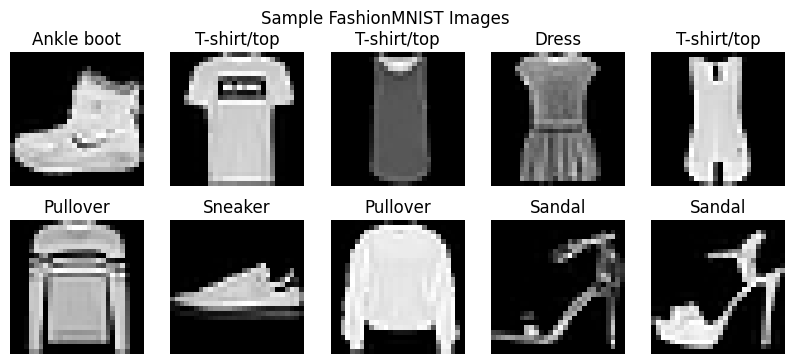

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,5, figsize=(10,4))
for i, ax in enumerate(axes.flatten()):
    img, label = train_set[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(train_set.classes[label])
    ax.axis('off')
plt.suptitle("Sample FashionMNIST Images")
plt.show()


### Create Dataloaders:

Dataloaders are variables that manage your data: It holds the dataset, and helps pass the next image to you after you are done processing the first one.

It can also transform your data. Notice that we have 60,000 images. Sometimes we might have less data or the data is very bad. To make our model more robust, we can add transformations like flipping the image or rotating it.  

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])
train_aug = datasets.FashionMNIST('data', train=True, transform=transform_aug, download=False)
train_loader = DataLoader(train_aug, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)

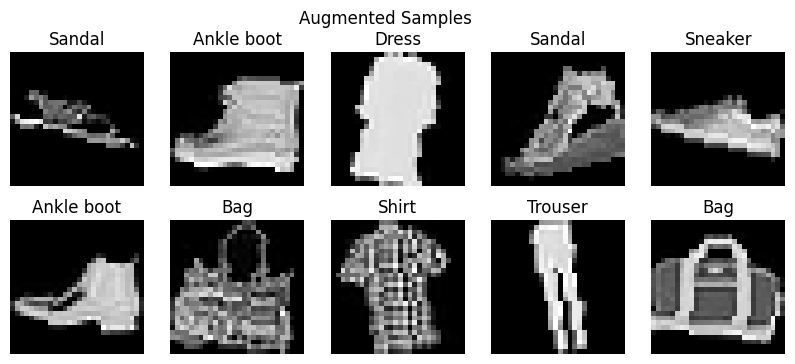

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(2,5, figsize=(10,4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(train_set.classes[labels[i]])
    ax.axis('off')
plt.suptitle("Augmented Samples")
plt.show()

### Creating a CNN

Now we will create a basic convolutional neural net using Pytorch. Torch already implements the basic CNN layer for us, so our job is just to stack it like Lego blocks.

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.fc1   = nn.Linear(64*7*7, 128)
        self.fc2   = nn.Linear(128, 10)
        self.relu  = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Used to tell torch which device to send to
model = SimpleCNN().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            401,536
├─Linear: 1-5                            1,290
├─ReLU: 1-6                              --
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0

### Training the CNN

Training the CNN allows it to better understand and improve its results, so it can tune its filters to better classify different articles of clothing.

`CrossEntropyLoss` is a way to determine how correct or wrong the model is, based on how confident it is for the correct and wrong answers. The more confident it is on a wrong answer, the higher the loss.

`Adam` is an optimizer, or an algorithm that tells the model how it should update and improve its weights to perform better.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 3

for epoch in range(1, epochs+1):
    running_loss = 0.0
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch} loss: {running_loss/len(train_loader):.4f}")

Epoch 1 loss: 0.5546
Epoch 2 loss: 0.3702
Epoch 3 loss: 0.3234


Test Accuracy: 89.10%


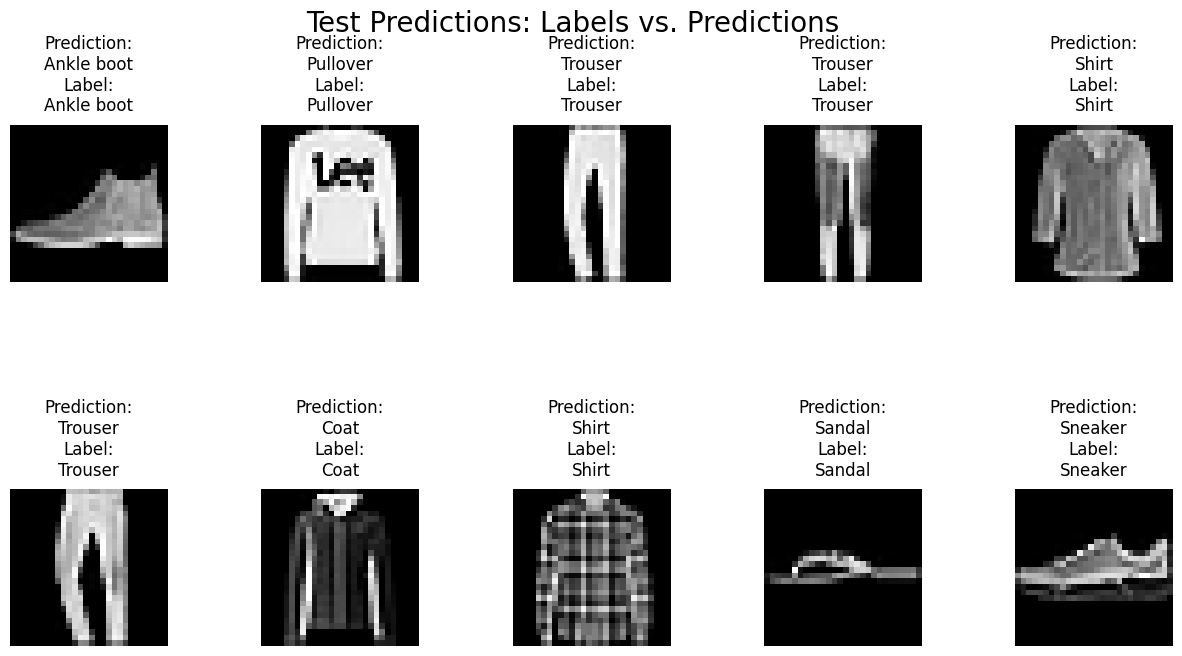

In [ ]:
model.eval() # This tells it to go to eval mode, so some functions in torch act differently
correct = total = 0

with torch.no_grad(): # This tells it not to track gradients, to make it faster.
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        # The model outputs a list of probabilites:
          # eg. [0.05, 0.2, 0.4, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
        preds = out.argmax(dim=1) #This finds out which index has the highest value
        #Eg. 0.4 is at index 2 so output is 2

        correct += (preds == y).sum().item() #Checks label (also a index) with predicted
        total   += y.size(0)

print(f"Test Accuracy: {100*correct/total:.2f}%")

# display a few predictions
import matplotlib.pyplot as plt

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
outs = model(images)
preds = outs.argmax(dim=1)

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
# add space between subplots and room for title
plt.subplots_adjust(wspace=0.6, hspace=0.6, top=0.85)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    # explicit "Prediction" and "Label"
    ax.set_title(f"Prediction:\n{train_set.classes[preds[i]]}\nLabel:\n{train_set.classes[labels[i]]}", pad=10)
    ax.axis('off')

plt.suptitle("Test Predictions: Labels vs. Predictions", fontsize=20, y=0.95)
plt.show()

### YOLO: You Only Look Once

- YOLO is a object detection algorithm that is well known for being fast to train and do inference on. A popular library to train YOLO is Ultralytics, which is a user-friendly library that provides easy training, inference and exporting of YOLO-series models.

To start training, we first need to prepare the dataset files.

Ultralytics expects a format commonly called "YOLO format", which is different from "COCO format" that some other libraries use (and what you may be given in). COCO format is in JSON while YOLO format is in txt. There are conversion scripts to convert from JSON to YOLO here: https://github.com/ultralytics/JSON2YOLO. Instructions are included.

The YOLO format requires that:

1. Images to be placed separately in a subfolder that follows the pattern dataset_root/split/images
2. Labels to be placed separately in a subfolder that follows the pattern dataset_root/split/labels
3. For each image in the images folder (e.g. image_1.png, image_2.png...), there must be a corresponding txt file named the same in the labels folder (e.g. image_1.txt, image_2.txt)
4. Each txt file contains one of more lines that represent all bounding boxes in that image. Each line is in class_id x_center y_center width height format, where xywh are normalized between 0 and 1. If your labels are not normalized, you should divide x_center and width by image width, and y_center and height by image height. Example of a label txt file:

0 0.6157894736842106 0.27586206896551724 0.031578947368421054 0.17471264367816092
0 0.6868421052631579 0.10804597701149425 0.015789473684210527 0.03218390804597701
0 0.4881578947368421 0.6206896551724138 0.05 0.0735632183908046
0 0.3815789473684211 0.16091954022988506 0.07368421052631578 0.05517241379310345

Note that both dataset_root and split can be set by you and not necessarily "train"/"val" etc.

Then, we need to prepare the dataset config YAML, which specifies your dataset_root and split names. We will use the %%writefile magic command here to write the config file, but you can also just copy and paste using any text editor.

The config file below set the dataset_root as "dataset", and specified train split to be called "train" and val split to be called "val". Thus, the directory structure should look like:
```text
dataset
    ├───train
    │   ├───images
    │   └───labels
    └───val
        ├───images
        └───label
```

### Training the model:

In [ ]:
from ultralytics import YOLO

# Load a small model and train on COCO128
model = YOLO('yolo11n.pt')
results = model.train(data='coco128.yaml', epochs=5, imgsz=640)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 111MB/s]

Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=


WARNING ⚠️ Dataset 'coco128.yaml' images not found, missing path '/content/datasets/coco128/images/train2017'


100%|██████████| 6.66M/6.66M [00:00<00:00, 115MB/s]
Unzipping /content/datasets/coco128.zip to /content/datasets/coco128...: 100%|██████████| 263/263 [00:00<00:00, 1147.44file/s]

Dataset download success ✅ (1.1s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 18.8MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

YOLO11n summary: 181 layers, 2,624,080 parameters, 2,624,064 gradients, 6.6 GFLOPs

Transferred 499/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:269: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:278: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1607.3±652.1 MB/s, size: 50.9 KB)


train: Scanning /content/datasets/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 2495.31it/s]

train: New cache created: /content/datasets/coco128/labels/train2017.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 412.4±152.7 MB/s, size: 52.5 KB)


val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1323: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1325: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all        128        929      0.694      0.592      0.675      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1323: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1325: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all        128        929      0.694      0.604      0.686      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1323: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1325: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all        128        929      0.704      0.605      0.693      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1323: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1325: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all        128        929      0.745      0.596      0.696      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1323: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1325: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all        128        929      0.752      0.587      0.697      0.532



5 epochs completed in 0.006 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:269: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:278: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1323: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1325: UserWarning: Deterministic behavior was enabled with either `torch.u

                   all        128        929      0.752      0.587      0.698      0.533
                person         61        254      0.855      0.626      0.788      0.549
               bicycle          3          6      0.647      0.167      0.469      0.296
                   car         12         46      0.816      0.196      0.274      0.182
            motorcycle          4          5      0.753          1      0.995      0.813
              airplane          5          6       0.88      0.833      0.931      0.846
                   bus          5          7      0.887      0.714      0.722      0.648
                 train          3          3      0.682      0.667      0.913      0.821
                 truck          5         12      0.646       0.25      0.474      0.296
                  boat          2          6      0.921        0.5       0.68      0.448
         traffic light          4         14      0.557      0.143      0.237      0.161
             stop sig

### Inference

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolo11n.pt')  # load an official model
# model = YOLO('runs/detect/train/best.pt')  # load a custom model

# Predict with the model
results = model.predict(['https://ultralytics.com/images/bus.jpg'], iou=0.3, conf=0.5)

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    probs = result.probs  # Probs object for classification outputs
    result.save(filename='result.jpg')  # save the visualized result
    # result.show()  # display to screen, does not work on a cloud VM/Vertex AI/Colab







0: 640x480 4 persons, 1 bus, 44.3ms
Speed: 2.7ms preprocess, 44.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


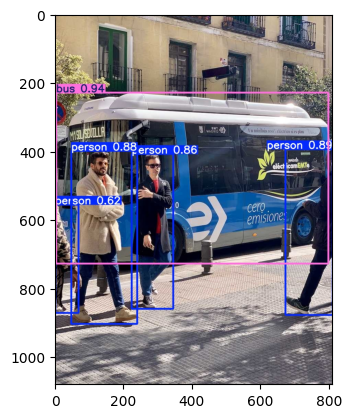

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open('result.jpg'))
plt.show()


### OCR Training

### Optical Character Recognition
This notebook is adapted from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb with fixes and updates.

In this notebook, we are going to fine-tune a TrOCR model on the IAM Handwriting Database, a collection of annotated images of handwritten text.

We will do this using the new VisionEncoderDecoderModel class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text. This also means that you can construct your own VisionEncoderDecoderModel using another Transformer image encoder and Decoder of your choice. There are more recent, smaller ones for you to try. However, note that without large-scale pre-training, it may not outperform the pre-trained TrOCR model.

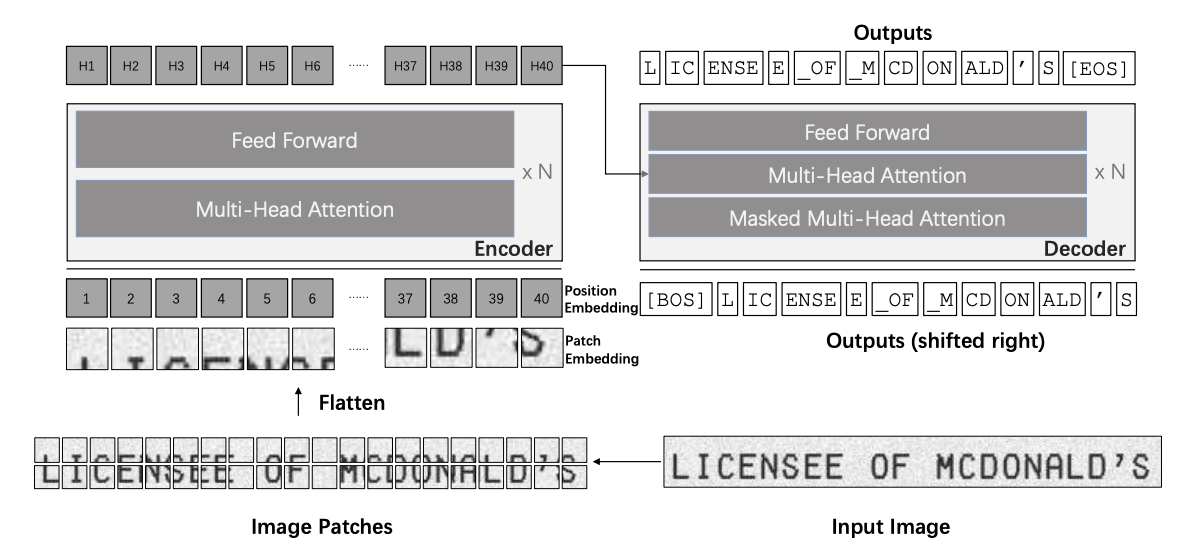

### Prepare Data


We will be using the IAM dataset, which is proposed in 2002 The IAM-database: an English sentence database for offline handwriting recognition. It contains scanned images of hand-written English text from 657 writers, for a total of 115320 words. The labels contain the bounding box and the text of each word.

We first download the data. It can be downloaded from [this page](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database). Note that you need to move all images in each subfolder into a common folder and name that 'images'. This code assumes this has already been done. We will be using a small subset of 104 images from the dataset to make demo faster. This subset with re-organized file structure and folder name has been zipped and provided as part of learning resource with this notebook.

We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text. The labels is provided in txt in the following format:
```text
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
```



# Downlaoding data

In [ ]:
!curl -L -o handwrite.zip https://www.kaggle.com/api/v1/datasets/download/nibinv23/iam-handwriting-word-database

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1129M  100 1129M    0     0  63.5M      0  0:00:17  0:00:17 --:--:-- 64.9M


In [ ]:
!rm -rf iam_words/
!unzip handwrite.zip

Streaming output truncated to the last 5000 lines.
  inflating: iam_words/words/p06/p06-069/p06-069-03-07.png  
  inflating: iam_words/words/p06/p06-069/p06-069-03-08.png  
  inflating: iam_words/words/p06/p06-069/p06-069-03-09.png  
  inflating: iam_words/words/p06/p06-069/p06-069-03-10.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-00.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-01.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-02.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-03.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-04.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-05.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-06.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-00.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-01.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-02.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-03.png  
  inflating: iam_words/words/p06/p

We will collect a subset of training data instead of the full file.

In [ ]:
# This prunes the dataset for easier training

!find iam_words/words/ -mindepth 1 -maxdepth 1 -type d ! -name 'a01' -exec rm -rf {} +
!find iam_words/words/a01 -mindepth 1 -maxdepth 1 -type d ! -name 'a01-000x' ! -name 'a01-000u' -exec rm -rf {} +


Creates images directory

In [ ]:
# 1. create the target folder
!mkdir -p iam_words/images

# 2. find all regular files under a01/ and copy them into images/
!find iam_words/words/a01/ -type f -print0 | xargs -0 cp -t iam_words/images/


We will read the txt and extract the relevant information (filename and text only).

In [ ]:
import pandas as pd

with open('words_new.txt', 'r') as f:
    lines = f.read().splitlines()
    lines = [line.split() for line in lines]
    lines = [{'file_name': line[0], 'text': line[-1]} for line in lines if line[0].startswith("a01-000u") or line[0].startswith("a01-000x") ]

df = pd.DataFrame(lines)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
# some file names end with jp instead of jpg, let's fix this
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()



,file_name,text
0,a01-000u-00-00,A
1,a01-000u-00-01,MOVE
2,a01-000u-00-02,to
3,a01-000u-00-03,stop
4,a01-000u-00-04,Mr.




We split up the data into training + testing, using sklearn's train_test_split function.


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)





Now we will construct a PyTorch Dataset. Each element of the dataset should return 2 things:

- pixel_values, which serve as input to the model.
- labels, which are the input_ids of the corresponding text in the image.

We use TrOCRProcessor to prepare the data for the model. TrOCRProcessor is actually just a wrapper around a ViTFeatureExtractor (which can be used to resize + normalize images) and a RobertaTokenizer (which can be used to encode and decode text into/from input_ids).


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx] + '.png'  # the filenames in txt does not include file extension
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding





Let's initialize the training and evaluation datasets:


In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten", use_fast=True)  # larger and printed text version exist too
train_dataset = IAMDataset(root_dir='iam_words/images/', df=train_df, processor=processor)
eval_dataset = IAMDataset(root_dir='iam_words/images/', df=test_df, processor=processor)



In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 83
Number of validation examples: 21




Let's verify an example from the training dataset:


In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)


pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])




We can also check the original image and decode the labels:


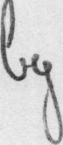

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0] + '.png').convert("RGB")
image



In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

by


### Train a model

Here, we initialize the TrOCR model from its pretrained weights.


In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten").cuda()

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 384,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]



Importantly, we need to set a couple of attributes, namely:

- the attributes required for creating the decoder_input_ids from the labels (the model will automatically create the decoder_input_ids by shifting the labels one position to the right and prepending the decoder_start_token_id, as well as replacing ids which are -100 by the pad_token_id)
- the vocabulary size of the model (for the language modeling head on top of the decoder)
- beam-search related parameters which are used when generating text.



In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.generation_config.eos_token_id = processor.tokenizer.sep_token_id
model.generation_config.max_length = 64
model.generation_config.early_stopping = True
model.generation_config.no_repeat_ngram_size = 3
model.generation_config.length_penalty = 2.0
model.generation_config.num_beams = 4



Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,  # this is needed because it is a generative language model, it generates text autoregressively
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=1,
    save_steps=100,
    eval_steps=10,
    report_to='none'  # change to 'wandb' or 'tensorboard' if you want to log to these platforms
)



We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [ ]:
from evaluate import load

cer_metric = load("cer")





The compute_metrics function takes an EvalPrediction (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:

- predictions: the predictions by the model.
- label_ids: the actual ground-truth labels.



In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}



Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.


In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    processing_class=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,3.987600
2,5.256000
3,3.590200
4,3.917800
5,3.459000
6,5.000500
7,4.190400
8,3.530700
9,3.464100
10,3.319700


TrainOutput(global_step=33, training_loss=3.2204090067834565, metrics={'train_runtime': 25.6119, 'train_samples_per_second': 9.722, 'train_steps_per_second': 1.288, 'total_flos': 2.978654716742861e+16, 'train_loss': 3.2204090067834565, 'epoch': 3.0})

### Evaluate

Since we only trained on 80+ images, our model would not work very well, and you can see the cer is very high at 124%. However the loss is coming down which means our training code is working at least.


In [ ]:
trainer.evaluate()

{'eval_loss': 4.520427703857422,
 'eval_cer': 1.2465753424657535,
 'eval_runtime': 1.888,
 'eval_samples_per_second': 11.123,
 'eval_steps_per_second': 1.589,
 'epoch': 3.0}


### Saving the model

In addition to the model itself you must also save the processor (which includes config for feature extractor and tokenizer).


In [ ]:
trainer.save_model('trocr-finetune')
processor.save_pretrained('trocr-finetune')



[]

### Inference

Again, because our model is not expected to be performing with high accuracy now, the inference results here just demonstrate that the code works.


In [ ]:
# load the model (only run this if you did not train the model in the same notebook session, else you can use the existing model object directly since it will contain the updated weight. Loading it again may lead to CUDA out of memory error.
model = VisionEncoderDecoderModel.from_pretrained('trocr-finetune').cuda()
processor = TrOCRProcessor.from_pretrained('trocr-finetune')



Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 384,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_

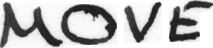

In [ ]:
# load the image
from PIL import Image

image = Image.open('iam_words/images/a01-000u-00-01.png').convert("RGB")
image



In [ ]:
# apply processor, remember to move the processed tensor to GPU if your model is on GPU too
pixel_values = processor(image, return_tensors="pt").pixel_values.cuda()
print(pixel_values.shape)



torch.Size([1, 3, 384, 384])


In [ ]:
# run inference to get text
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

from the
